In [1]:
import string
import random
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns

#### Prepare for Dataset

In [2]:
all_chars       = string.printable
n_chars         = len(all_chars)
file            = open('./shakespeare.txt').read() #change if image captioning
file_len        = len(file)

print('Length of file: {}'.format(file_len))
print('All possible characters: {}'.format(all_chars))
print('Number of all possible characters: {}'.format(n_chars))

Length of file: 1115394
All possible characters: 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~ 	

Number of all possible characters: 100


In [3]:
# Get a random sequence of the Shakespeare dataset.
def get_random_seq():
    seq_len     = 128  # The length of an input sequence.
    start_index = random.randint(0, file_len - seq_len)
    end_index   = start_index + seq_len + 1
    return file[start_index:end_index]

# Convert the sequence to one-hot tensor.
def seq_to_onehot(seq):
    tensor = torch.zeros(len(seq), 1, n_chars) 
    # Shape of the tensor:
    #     (sequence length, batch size, classes)
    # Here we use batch size = 1 and classes = number of unique characters.
    for t, char in enumerate(seq):
        index = all_chars.index(char)
        tensor[t][0][index] = 1
    return tensor

# Convert the sequence to index tensor.
def seq_to_index(seq):
    tensor = torch.zeros(len(seq), 1)
    # Shape of the tensor: 
    #     (sequence length, batch size).
    # Here we use batch size = 1.
    for t, char in enumerate(seq):
        tensor[t] = all_chars.index(char)
    return tensor

#change if image captioning
# Sample a mini-batch including input tensor and target tensor.
def get_input_and_target():
    seq    = get_random_seq()
    input  = seq_to_onehot(seq[:-1])      # Input is represented in one-hot.
    target = seq_to_index(seq[1:]).long() # Target is represented in index.
    return input, target

#### Choose a Device

In [4]:
# If there are GPUs, choose the first one for computing. Otherwise use CPU.
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)  
# If 'cuda:0' is printed, it means GPU is available.

cuda:0


#### Network Definition

In [5]:
class Net(nn.Module):
    def __init__(self):
        # Initialization.
        super(Net, self).__init__()
        self.input_size  = n_chars   # Input size: Number of unique chars.
        self.hidden_size = 100       # Hidden size: 100.
        self.output_size = n_chars   # Output size: Number of unique chars.
        
        #self.rnn = nn.RNNCell(self.input_size, self.hidden_size) #change this to LSTM to GRU
        self.rnn = nn.LSTM(self.input_size, self.hidden_size, 2)
        self.linear = nn.Linear(self.hidden_size, self.output_size)
        ###### To be filled ######
        ###### To be filled ######
    
    def forward(self, input, hidden):
        """ Forward function.
              input:  One-hot input. It refers to the x_t in homework write-up.
              hidden: Previous hidden state. It refers to the h_{t-1}.
            Returns (output, hidden) where output refers to y_t and 
                     hidden refers to h_t.
        """
        # Forward function.
        #hidden = self.rnn(input,hidden)###### To be filled ######
        #print(input.shape)
        #print(hidden.shape)
        output,(h0,c0) = self.rnn(input,hidden)
        hidden = (h0,c0)
        #output =self.linear(hidden) ###### To be filled ######
        output = self.linear(output)
        #print(self.output.size)

        return output, hidden

    def init_hidden(self):
        # Initial hidden state.
        # 1 means batch size = 1.
        return (torch.zeros(2, 1,self.hidden_size).to(device),torch.zeros(2, 1,self.hidden_size).to(device)) 
    
net = Net()     # Create the network instance.
net.to(device)  # Move the network parameters to the specified device.

Net(
  (rnn): LSTM(100, 100, num_layers=2)
  (linear): Linear(in_features=100, out_features=100, bias=True)
)

#### Training Step and Evaluation Step

In [6]:
output_list = []
# Training step function.
def train_step(net, opt, input, target):
    """ Training step.
        net:    The network instance.
        opt:    The optimizer instance.
        input:  Input tensor.  Shape: [seq_len, 1, n_chars].
        target: Target tensor. Shape: [seq_len, 1].
    """
    seq_len = input.shape[0]    # Get the sequence length of current input.
    hidden = net.init_hidden()  # Initial hidden state.
    net.zero_grad()             # Clear the gradient.
    loss = 0                    # Initial loss.

    #for t in range(seq_len):    # For each one in the input sequence.
   # print("target.shape")
    #print(target.shape)
    output, hidden = net(input, hidden)
    output = output.reshape(seq_len,-1)
    target = target.reshape(-1)
    output_list.append(output)
    #print("target.shape")
    #print(target.shape)
    #print("output.shape")
    #print(output.shape)
    
    loss += loss_func(output, target)

    loss.backward()             # Backward.  #comment if not update model
    opt.step()                  # Update the weights. #comment if not update model

    return loss / seq_len       # Return the average loss w.r.t sequence length.

In [14]:
# Evaluation step function.
#output_list = []
def eval_step(net, init_seq='W', predicted_len=100):
    # Initialize the hidden state, input and the predicted sequence.
    hidden        = net.init_hidden()
    init_input    = seq_to_onehot(init_seq).to(device)
    predicted_seq = init_seq

    # Use initial string to "build up" hidden state.
    #for t in range(len(init_seq) - 1):
    #output, hidden = net(init_input, hidden)
        
    # Set current input as the last character of the initial string.
    input = init_input
    
    #print(output.shape)
    # Predict more characters after the initial string.
    for t in range(predicted_len):
        
        output, hidden = net(input, hidden)
        
        #output_list.append(output)
        
        # Get the current output and hidden state.
        #output_t = output[t]
        
        #output, hidden = net(input[t].reshape(, hidden)
        
        # Sample from the output as a multinomial distribution.
        predicted_index = torch.multinomial(output.view(-1).exp(), 1)[0]
        
        # Add predicted character to the sequence and use it as next input.
        predicted_char  = all_chars[predicted_index]
        predicted_seq  += predicted_char
        
        # Use the predicted character to generate the input of next round.
        input = seq_to_onehot(predicted_char).to(device)

    return predicted_seq

#### Training Procedure

In [95]:
# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.02664029784500599
generated sequence: Wo:rtg
d,lfle tdsaseher,Mhgio
 l doc  nree r en rttoro:
uI dsthhrfeahetee h 
edhue le
 r uRo tt
Ofarh

iter:199/15000 loss:0.02509143017232418
generated sequence: Wv 
hNfpibndeay creueeGs nou  vRthe EKNNh? cunar, metmeor Idpses yr,
ted
tyer wesitetirn iNmh tn
n ln

iter:299/15000 loss:0.02200070023536682
generated sequence: W thaaib trer led Ahe shain , iw: boafirrany ket, yraleeip, wos m mour os?

HiOSI
VEUUAEO
I ISy s rer

iter:399/15000 loss:0.019878670573234558
generated sequence: Wat kithur hertf the Vastereod:

:
Iurell

f of Ondive ty wo yyo Agisd nostas.
Aut cpag nathou ther b

iter:499/15000 loss:0.0192245040088892
generated sequence: W
suw, thy if ao; apesillsy,
We critud
Toud inn
haos thet bry to s mane rith axbeusd.
thave pallhe yi

iter:599/15000 loss:0.0186650101095438
generated sequence: WI mlas:
To moamiart of p ach, carlale yoze, indbinccaes'eed selileis, wo, I thor.

DNINY:
sess thy c

iter:699/15000 loss:0.01

#### Training Loss Curve

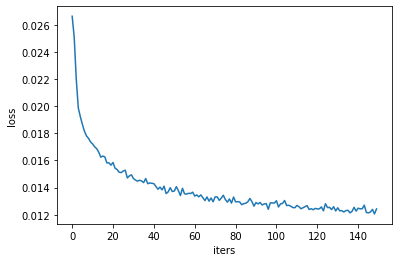

In [96]:
plt.xlabel('iters')
plt.ylabel('loss')
plt.plot(all_losses)
plt.show()

#### Evaluation: A Sample of Generated Sequence

In [97]:
print(eval_step(net, predicted_len=600))

With themsels, good with now, do;
Since Keem.

TTAN:
Go that you are farewell, and his touch my heartsy uppare to rups citiler will be sterms! neats Ques it that stentious his part I know the triught of her plearer lost to do the none yet, and bring to this but now to they I a need.
Likes by and speaky mine queen on mores, I am wise father soun! Volintance.
They reating deuzes' Warwick and give not stepke pall the known. While.

STRARD LAHN:
As for a
know on him, I will see year an and fife
Whose infict old protess; Marcius of desire and tuth these make your such court, to fielding from an all 


In [ ]:
#I have two models
#testing when comparing two models: retrain the same datasets on the new_train_method where update model is commented, compare the loss of model1 and model2, greater = bad 

In [8]:
#second trial of LSTM
# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.026987764984369278
generated sequence: WAogdwhm !daktdh:ulr s:tesabahs srylvae.shwh YdeA Amn YtneaUe RiWmaOcdtSAurs  wc f e,
soIhA
 ,,dh aGu

iter:199/15000 loss:0.025606190785765648
generated sequence: Wuuf bhit
ty ihh Ilanoiwr t ge yo:Ruw  ee tsoibg
yo el
?l ne,EOfateh eeft sh eRro'laye
#of WtCb:
B:il

iter:299/15000 loss:0.022124499082565308
generated sequence: Wngxrias loivt yos th 
IOI:
LRHCUIIIIDCNIOIMHIIIs
T:

/NIIAUXASRWTCUIAA A:

#VRIAAOE::
W:
mraalols hu

iter:399/15000 loss:0.020197752863168716
generated sequence: Wh hy fherd,

L:
Got'! wok westar:
An thino? hutd fred milt dmonpy yhiod:

f CaI: 
Tlot:
ir woan love

iter:499/15000 loss:0.019205668941140175
generated sequence: Whisd in rotle'l ming?
Tress:
I meves, mor! thegt yreyinte solo,
Mrath hal.
The samn thar here the di

iter:599/15000 loss:0.01869734562933445
generated sequence: Wo yiop suwun yeun.

QONYEMO:

BMTETINL::

OME:
Sfind lpesenis cimt silk woure awlve dinr!
Nyar tor t

iter:699/15000 los

In [12]:
# Draw the heatmap of training errors.
def draw_heatmap1d(probability, char_list,title):
    plt.figure(figsize = (2,4))
    ax = sns.heatmap(probability, annot=True, fmt='.3f', 
                     yticklabels=char_list)
    ax.collections[0].colorbar.set_label("accuracy")
    #ax.set( ylabel='%s'%(y_name))#'$\gamma$', ylabel='$C$')
    plt.title('visualization of %s' % (title))
    b, t = plt.ylim() # discover the values for bottom and top
    b += 0.5 # Add 0.5 to the bottom
    t -= 0.5 # Subtract 0.5 from the top
    plt.ylim(b, t) # update the ylim(bottom, top) values
    plt.show()

In [8]:
# Number of iterations.
iters       = 15000  # Number of training iterations.
print_iters = 100    # Number of iterations for each log printing.

# The loss variables.
all_losses = []
loss_sum   = 0

# Initialize the optimizer and the loss function.
opt       = torch.optim.Adam(net.parameters(), lr=0.005)
loss_func = nn.CrossEntropyLoss()

# Training procedure.
for i in range(iters):
    input, target = get_input_and_target()            # Fetch input and target.
    input, target = input.to(device), target.to(device) # Move to GPU memory.
    loss      = train_step(net, opt, input, target)   # Calculate the loss.
    loss_sum += loss                                  # Accumulate the loss.

    # Print the log.
    if i % print_iters == print_iters - 1:
        print('iter:{}/{} loss:{}'.format(i, iters, loss_sum / print_iters))
        print('generated sequence: {}\n'.format(eval_step(net)))
              
        # Track the loss.
        all_losses.append(loss_sum / print_iters)
        loss_sum = 0

iter:99/15000 loss:0.026748184114694595
generated sequence: Whu laco
 7w sn dwi a  lgAgfarodelaamhnm .c'duoU h e ,mDC
t rwtOh  htt en nhnen  hhetxecacIsca

eRth 

iter:199/15000 loss:0.025732167065143585
generated sequence: WEukL tsretnufu
GIhc tnr vwuo taro Atleitogat ge so
 NwuiasMus

t bos fe soleetseee t y nerlLtesme ] 

iter:299/15000 loss:0.022172892466187477
generated sequence: Whehid owhin
Iotd, bichuld folg,.
Co K
ESNNUP Yo p am roch hast meopl.k thasde
Whaskl thas ate n nhiI

iter:399/15000 loss:0.01972022093832493
generated sequence: Wamor bogont it:pdls as ant theut waslissb briin.
Shan th? yuud jeum toe, hind thiry
Ruv relr er: tan

iter:499/15000 loss:0.01905338279902935
generated sequence: Whee is nor o mol'the Wrome nreat mide,
Wo deich gucte suefer 'te Yinoa

KTADBLEL:
Cafwerher woull wa

iter:599/15000 loss:0.018486764281988144
generated sequence: Wardtas,, soaourd shapend
cetomawir asttensens: uny mawitarey toy amy dad ald theel tot te petonteres

iter:699/15000 loss

In [9]:
output_list
softmax = nn.Softmax(dim = -1)
temp = softmax(torch.stack(output_list))
print(temp.shape)

#np.array(softmax(torch.stack(output_list)).reshape(1,-1)).shape

torch.Size([15000, 1, 1, 100])


In [10]:
prob, index = torch.max(temp[-1],-1)

In [16]:
#prob, index = torch.max(temp[8000],-1)

tensor([[96]], device='cuda:0')

In [56]:
#output_list[0].shape
index.shape

torch.Size([128])

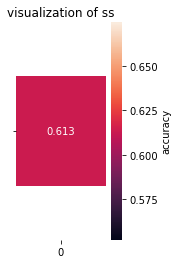

'\n'

In [13]:
char_list = [all_chars[i] for i in index]#["I","W","Y"] #sentence from validation file. Could be a selection from training file.
import numpy as np
draw_heatmap1d(np.array(prob.cpu().detach()).reshape(-1,1),char_list,'ss')
"".join(char_list)

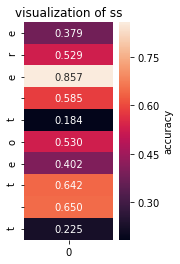

'ere toet t'

In [84]:

char_list = [all_chars[i] for i in index[108:118]]#["I","W","Y"] #sentence from validation file. Could be a selection from training file.
import numpy as np
draw_heatmap1d(np.array(prob[108:118].cpu().detach()).reshape(-1,1),char_list,'ss')
"".join(char_list)
#each cell higher prob the better ->fits ground truth
# tere toet t\hoer ed

In [73]:
len(output_list)
anyway = output_list[-1]
#anyway.shape
test_prob, test_idx = torch.max(softmax(anyway),-1)

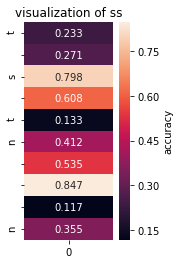

In [75]:
draw_heatmap1d(np.array(test_prob[:10].cpu().detach()).reshape(-1,1),[all_chars[i] for i in test_idx[:10]],'ss')